# Chapter 19 -  **Chapter name here**

Add summary

Add intro.

## 1. ORGANISE YOUR WORKSPACE

Create a folder in which you can store all your experiments. After a lot of testing it will be easy to feel lost. Give your experiment a name and create a folder in a chosen directory with the same name.

In [3]:
import os

experiment_name = "example"
if not os.path.exists("./results/" + experiment_name + "/"):
    os.makedirs("./results/" + experiment_name + "/")

## 2. DEFINE YOUR PROBLEM 

The first step in your machine learning pipeline is to define your problem. To do this you will need to first load your data and then define feature set X and the corresponding labels y.

### 2.1. Loading the data

In this example, we will use tabular data with features as columns and rows as participants. The data are saved as a csv file. We will use the library pandas to load and explore the data. The first thing we need to do is import the pandas library. To make the code simpler, it is common to import it as pd. This way, we simply type "pd" everytime we want to call the pandas library. From pandas, we use the function read_csv() to load the csv file containing our data. This will transform the data into an object called dataframe.
#Fix: add link to dummy data??

In [4]:
import pandas as pd

data = pd.read_csv("./Chapter_19_data.csv")

Let's start by seeing the first six rows of the data. Selecting subsections ("slicing") of a dataframe using pandas is straighforward. There are different ways to do this. Here, we use loc to select the first five rows (note that the first column is indexed 0 and the last column is not included).

In [5]:
data.loc[0:5]

,ID,label,Gender,Age,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,...,rh_rostralanteriorcingulate_thickness,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness
0,c001,0,0,35,4226.907844,414.407845,12242.90784,43410.50784,7020.107844,4133.407844,...,2.440844,2.522844,2.656844,2.123844,2.638844,2.420844,2.489844,2.235844,2.300844,2.645844
1,c002,0,1,37,4954.912699,414.812699,16519.51270,38808.31270,7013.312699,3882.912699,...,2.507699,2.470699,2.645699,2.132699,2.848699,2.425699,2.883699,2.622699,2.322699,2.673699
2,c003,0,1,32,4470.611989,370.111989,10193.51199,38637.51199,5802.911989,2941.711989,...,2.545989,2.589989,2.885989,2.317989,2.326989,2.454989,2.482989,2.232989,2.267989,2.795989
3,c004,0,1,36,7553.310654,521.010654,12716.01065,41933.31065,5998.310654,2869.110654,...,2.323654,2.411654,2.770654,2.149654,2.458654,2.307654,3.284654,1.956654,2.297654,2.731654
4,c005,0,0,22,8785.212771,396.912771,12077.41277,41818.91277,5839.812771,3614.812771,...,3.211771,2.467771,2.772771,2.051771,2.588771,2.325771,3.266771,3.162771,2.081771,2.607771
5,c006,0,1,34,5083.706643,172.106643,11927.50664,38730.80664,5693.506643,3422.606643,...,2.562643,2.603643,2.948643,2.177643,2.489643,2.362643,2.314643,3.512643,2.591643,2.606643


We can see the features names at the top and the data for the first six participants. Features include the ID, age and gender, as well as the gray matter volume for several brain regions. We can see that there is at least one value missing. We will deal with this later. 

It may be useful to know all the features that are avaiable in the dataset. To do this, we simply ask for the names of the columns of our data.

In [9]:
data.columns.tolist()

['ID',
 'label',
 'Gender',
 'Age',
 'Left_Lateral_Ventricle',
 'Left_Inf_Lat_Vent',
 'Left_Cerebellum_White_Matter',
 'Left_Cerebellum_Cortex',
 'Left_Thalamus_Proper',
 'Left_Caudate',
 'Left_Putamen',
 'Left_Pallidum',
 'rd_Ventricle',
 'th_Ventricle',
 'Brain_Stem',
 'Left_Hippocampus',
 'Left_Amygdala',
 'CSF',
 'Left_Accumbens_area',
 'Left_VentralDC',
 'Right_Lateral_Ventricle',
 'Right_Inf_Lat_Vent',
 'Right_Cerebellum_White_Matter',
 'Right_Cerebellum_Cortex',
 'Right_Thalamus_Proper',
 'Right_Caudate',
 'Right_Putamen',
 'Right_Pallidum',
 'Right_Hippocampus',
 'Right_Amygdala',
 'Right_Accumbens_area',
 'Right_VentralDC',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'lh_bankssts_volume',
 'lh_caudalanteriorcingulate_volume',
 'lh_caudalmiddlefrontal_volume',
 'lh_cuneus_volume',
 'lh_entorhinal_volume',
 'lh_fusiform_volume',
 'lh_inferiorparietal_volume',
 'lh_inferiortemporal_volume',
 'lh_isthmuscingulate_volume',
 'lh_lateralo

Now that we know what features we are dealing with, let's check the size of the data.

In [13]:
print("Number of features =", data.shape[1])
print("Number of participants =", data.shape[0])

Number of features = 173
Number of participants = 740


### 2.2. Define your feature set and target

The target is a categorical variable that determines whether a participant belongs to the HC and SZ group. Therefore, we will refer to the target variable as labels. This variable corresponds to the column named "label" in the dataframe. To create a new variable y with these data, we simply retrieve this column from the dataframe "data". Defining the features in the same way would be impractical, since the are too many to be named individually. Instead, we can select a range of columns based on their location. We already know that there are 173 features in the original data. However, not all are brain region volumes; the relevant features for our model start from the 5th column. Therefore, we select the columns of the dataframe accordingly by retrieving a selection of the data containing all rows from the 5th column onwards. 

In [17]:
y = data["label"]
X = data[data.columns[4:]]

,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,Left_Putamen,Left_Pallidum,rd_Ventricle,th_Ventricle,Brain_Stem,Left_Hippocampus,Left_Amygdala,CSF,Left_Accumbens_area,Left_VentralDC,Right_Lateral_Ventricle,Right_Inf_Lat_Vent,Right_Cerebellum_White_Matter,Right_Cerebellum_Cortex,Right_Thalamus_Proper,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens_area,Right_VentralDC,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,lh_bankssts_volume,lh_caudalanteriorcingulate_volume,lh_caudalmiddlefrontal_volume,lh_cuneus_volume,lh_entorhinal_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_isthmuscingulate_volume,lh_lateraloccipital_volume,lh_lateralorbitofrontal_volume,lh_lingual_volume,lh_medialorbitofrontal_volume,lh_middletemporal_volume,lh_parahippocampal_volume,lh_paracentral_volume,lh_parsopercularis_volume,lh_parsorbitalis_volume,lh_parstriangularis_volume,lh_pericalcarine_volume,lh_postcentral_volume,lh_posteriorcingulate_volume,lh_precentral_volume,lh_precuneus_volume,lh_rostralanteriorcingulate_volume,lh_rostralmiddlefrontal_volume,lh_superiorfrontal_volume,lh_superiorparietal_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_frontalpole_volume,lh_temporalpole_volume,lh_transversetemporal_volume,lh_insula_volume,rh_bankssts_volume,rh_caudalanteriorcingulate_volume,rh_caudalmiddlefrontal_volume,rh_cuneus_volume,rh_entorhinal_volume,rh_fusiform_volume,rh_inferiorparietal_volume,rh_inferiortemporal_volume,rh_isthmuscingulate_volume,rh_lateraloccipital_volume,rh_lateralorbitofrontal_volume,rh_lingual_volume,rh_medialorbitofrontal_volume,rh_middletemporal_volume,rh_parahippocampal_volume,rh_paracentral_volume,rh_parsopercularis_volume,rh_parsorbitalis_volume,rh_parstriangularis_volume,rh_pericalcarine_volume,rh_postcentral_volume,rh_posteriorcingulate_volume,rh_precentral_volume,rh_precuneus_volume,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,lh_lateralorbitofrontal_thickness,lh_lingual_thickness,lh_medialorbitofrontal_thickness,lh_middletemporal_thickness,lh_parahippocampal_thickness,lh_paracentral_thickness,lh_parsopercularis_thickness,lh_parsorbitalis_thickness,lh_parstriangularis_thickness,lh_pericalcarine_thickness,lh_postcentral_thickness,lh_posteriorcingulate_thickness,lh_precentral_thickness,lh_precuneus_thickness,lh_rostralanteriorcingulate_thickness,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,rh_bankssts_thickness,rh_caudalanteriorcingulate_thickness,rh_caudalmiddlefrontal_thickness,rh_cuneus_thickness,rh_entorhinal_thickness,rh_fusiform_thickness,rh_inferiorparietal_thickness,rh_inferiortemporal_thickness,rh_isthmuscingulate_thickness,rh_lateraloccipital_thickness,rh_lateralorbitofrontal_thickness,rh_lingual_thickness,rh_medialorbitofrontal_thickness,rh_middletemporal_thickness,rh_parahippocampal_thickness,rh_paracentral_thickness,rh_parsopercularis_thickness,rh_parsorbitalis_thickness,rh_parstriangularis_thickness,rh_pericalcarine_thickness,rh_postcentral_thickness,rh_posteriorcingulate_thickness,rh_precentral_thickness,rh_precuneus_thickness,rh_rostralanteriorcingulate_thickness,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_supe

## 3. PREPARE YOUR DATA

In this step we want to get our data ready before we start analyse it. This can involve different analyses depending on the nature of your problem and type of features. 

In this example, we will check the data for the presence of:
 - Data imbalance with respect to the labels
 - Confounding variables
 - Missing data 

### 3.1. Class imbalance

First, let's check the number of total participants, features and number of participants in each class.  

In [20]:
print("Number of patients with schizophrenia (SZ) =", len(y[y == 0]))
print("Number of Healthy Control (HC) =", len(y[y == 1]))

Number of patients with schizophrenia (SZ) = 368
Number of Healthy Control (HC) = 372


From the output we can see that there are 740 participants in total, 368 patients and 372 controls. There does not seem to be a large imbalance between classes. However, they are not perfectly matched. One option would be to downsample the HC to match the SZ group. However, this would mean loosing some data. Since the imbalance is not too large, we will use balanced accuracy as our metric of choice as well as stratified CV to ensure the same proportion SZ/HC across the CV iterations. 


### 3.2. Confounding variables

Next, let's check for balance of some obvious confounding variables: gender and age. First, let's see the distribution of gender between the two classes. This time, we will use some plots from the seaborn library. Plotting data using seaborn is straighforward. For more information see https://seaborn.pydata.org. 

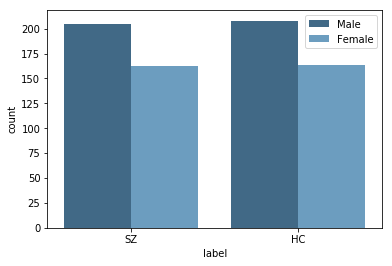

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.countplot(x="label", hue="Gender", data=data, palette="Blues_d")

plt.legend(["Male", "Female"])
plt.xticks([0,1], ["SZ", "HC"])

plt.show()

We can see that there is a fairly similar distribution of males and females in the two classes. Therefore, we will not consider gender as a significant confounder. 
- do not make assumptions by visual checking.

In [46]:
import scipy.stats as stats

tab = pd.crosstab(data["Gender"], data["label"])
print(tab)

chi2, p_value, _, _ = stats.chi2_contingency(tab, correction=False)
print(chi2)
print(p_value)

label     0    1
Gender          
0       205  208
1       163  164
0.0032283442354704628
0.9546897607994371


Next, let's check for any imbalance with respect to age by retrieving the mean age and standard deviation for each class.

In [48]:
mean = (data.groupby("label")["Age"].mean()).round(1)
sd = (data.groupby("label")["Age"].std()).round(1)
print("")
print("Mean age for HC =", mean[0],"±",sd[0])
print("Mean age for SZ =", mean[1],"±",sd[1])


Mean age for HC = 27.8 ± 7.6
Mean age for SZ = 27.6 ± 7.9


Perform t-test

In [60]:
age_sz = data[data['label']==0]['Age']
age_hc = data[data['label']==1]['Age']

statistic, p_value = stats.ttest_ind(age_sz, age_hc)
print(statistic)
print(p_value)

0.3303728873764387
0.7412119891941698


As shown in the output above, the mean and standard-deviations for age are indeed very similar between the SZ and HC groups. For this reason, we will not consider age as a significant confounder in this example.

Had there been a significant imbalance in gender or age (or any other relevant variable) there were several potential options to choose from. Perhaps the most obvious and simple one would be to match the groups with respect to these variables. Another popular option would be to regress out the confounding variables from each feature and using the residuals as the new features. For more information on confounding variables in neuroimaging and machine learning learning see Rao et al., 2017.

## 3.3. Missing data

Many machine learning algorithms do not support data with missing values. Therefore it is important to check if there are any missing values in our data. There are many different ways to do this. Here we will build our own function to loop through each the column in the dataframe data (note data we are also including gender and age) and get the feature name and Id for the corresponding missing values.

In [61]:
def detect_nan(dataset):
    nan_total = dataset.isnull().sum().sum() 
    if nan_total > 0:
        for column in dataset:          
            #Find Ids with nan - THIS IS PROBABLY OVERLY COMPLICATED (all I want here is to get the Ids of where the nans are so I can print them later on)
            nan = dataset[column].isnull()
            dataset["nan"] = nan 
            ids = []
            for i in dataset["nan"]:
                if i == True:
                    id_nan = dataset.loc[dataset["nan"] == True, 'ID']
                    ids.append(id_nan)               
            #Calculate total number of nan for each feature and Id
            nan_sum = nan.sum()          
            if nan_sum > 0:
                print("Found", nan_sum, "missing value(s) for", column, "for Id(s):", *ids[0])             
        #dataset = dataset.drop(columns=["nan"])
    else:
        print("There are no missing data in this dataset!")
        print("")
detect_nan(data)

There are no missing data in this dataset!



From the output we can see that there are 12 missing values for the feature Left Lateral Ventricle. There are several options to go from here with different degrees of complexity (see Chapter x for a more in-depth description). In this example, we will impute the data #missing for Left Lateral Ventricle. Recall that missing data should be imputed inside the cross validation (CV). Therefore, this step will be implemented this later.

FIX: At the moment thre is no missing data. I will remove some data to make it more interesting. This code works but I think it is probably overly complicated...I have to add and remove a column to the dataframe with booleans "nan" to identify NAN and it does not seem so intuitive. If you could find a cool way to simplify it, it would be great! 

## 4. FEATURE ENGINEERING

In this step, we want to make all the necessary transformations to our data that can help us build a good model. As described in Chapter 2, this can involve different procedures depending on the nature of the data. In this example, we want to use neuroanatomical data to classify SZ and HC.

### 4.1. Feature extraction

This first step involves extracting brain morphometric information from the raw MRI images. Luckily, this step has already been done for us. The regional grey matter volumes that make up our data X have been extracted with FreeSurfer (REF).

### 4.2. Cross-validation

Before we move on to apply any transformations to our feature set X, we need to split the data into train and test sets. Recall that this is a critical step to ensure independence between the training and test sets. There are different ways in which to do this. In this example, we will use stratified 10-fold cross-validation (CV). See Chapter 2 for an overview and rational of the most commonly used types of CV. 

We first transform the dataframe X into a 2D array of the same shape using the library numpy. For the purpose of this exercise, you can think of this as a 2x2 matrix. This will make it easier later on, as some of the functions will require the data to be in this format. 
import numpy as np 

In [ ]:
import numpy as np

X = np.asarray(X.values, dtype='float32')
y = np.asarray(y.values, dtype='float32')

Then, we define the parameters of our stratified CV scheme using the function StratifiedKFold from the sklearn library, and assign it to the variable skf.

Notice the hyperparamter random_state in the specification of the CV assigned to the variable skf. This hyperparamter allows us to control the element of randomness intrinsic to splitting the total data into train and test sets. In this example, our data comprises of 740 participants in total. In the code above, we have instructed the model to split it into 10 groups (whilst maintaining the SZ/HC ratio similar throughout the CV iterations). Now, there are multiple solutions to this task! Not setting this hyperparameter to a specific value means that, every time you run your code, the participants assigned to each group will differ! Consequently, your results will, very likely, differ as well*. This is something we would like to avoid, at least while we build upon our model to improve it, as we want to be able to reproduce the same results for comparison between different models.

*Importantly to brain disorders research, this is specially true for small sample sizes. For an interesting discussion on the relation between sample size, cross-validation and performance see Varoquax et al. 2018 and Nieuwenhuis et al. 2012.

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

 Now that the CV is defined, we can loop over each one of the 10 train/test set iterations. At each iteration, we will transform and fit the machine learning algorithm to the training set; and apply the same data transformations and test the algorithm in the test set. 

We can implement the above using a for loop to iterate over the 10 i_folds. At each i_fold, we will have four new variables:
 - X_train and y_train: training set and corresponding labels
 - X_test and y_test: test set and corresponding labels

Because we will be training and testing the machine learning algorithm one iteration at a time, we will create some empty variables where we can store important information from each iteration. In the code below we create four empty arrays of shape 10, one for each performance metric: balanced accuracy (bac), sensitivity (sens), specificity (spec) and error rate. Each array will be populated with each metric from each CV iteration. We also created an empty list coefficients. This is where we will store the weights (coefficient or "importance") from each feature across the CV iterations. Once the CV is finished, we can then calculate the average weight of each feature for the task.

In [ ]:
cv_test_bac = np.zeros((n_folds,))
cv_test_sens = np.zeros((n_folds,))
cv_test_spec = np.zeros((n_folds,))
cv_error_rate = np.zeros((n_folds,))
coefficients = []

for i_fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Let's check how many participants there are in the train and test sets in each iteration of the CV. We can do this by simply asking for the length of y.

In [ ]:
    print("")
    print("k-fold: ", i_fold + 1)
    print("N training set:", len(y_train))
    print("N test set:", len(y_test))

### 4.3. Data imputation

As we saw before, it was decided to use imputation to fill in the missing data for the feature Left Lateral Ventricle. There are several methods to implement this. In this example, we use the function Imputer from sklearn to 1) compute the mean value for this feature in the training set, and 2) replace all the missing values in the training and 3) test sets with the same mean value.

In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 1)
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

### 4.4. Feature scaling/normalization

Before making any transformation to our data, we want to make sure that the fact that different regions of the brain have different ranges will not affect our model. For example, the hippocampus will tend to be larger than the thalamus. If we keep the original values, the algorithm may mistakenly conclude that the hippocampus will be less important than region the thalamus. - IS THIS CORRECT?

There are several possible solutions to avoid this and other related issues. In this example, we will transform the data in such a way that the distribution of each feature will resemble a normal distribution (e.g. mean=0 and standard-deviation=1). Each new normalised value z is calculated by taking each data point xi, subtracting the mean x_ and then dividing it by the standard-deviation sd of the same feature:

zxi = (x_featureA - xi) / sdfeatureA

The code below normalises each feature independently using the function StandardScaler from sklearn.

First, we fit the function StandardScaler to the train set and store the parameters - x_ and sd - in the variable scaler. Then, we transform both the train and test set using the formula above with the stored parameters.

In [ ]:
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler().fit(X_train)
    X_train_n = scaler.transform(X_train)
    X_test_n = scaler.transform(X_test)    

Let's check what effect this had on the data. Let's select three features at random from the training set - columns 2, 65, and 100 - and plot each distribution before and after normalisation

In [ ]:
feature_2_before, feature_65_before, feature_100_before  = X_train[:,2], X_train[:,65], X_train[:,100]
feature_2_after, feature_65_after, feature_100_after = X_train_n[:,2], X_train_n[:,65], X_train_n[:,100]

import matplotlib.pyplot as plt
import seaborn as sns

p1_before=sns.kdeplot(feature_2_before, color="r", label=("Feature 2 before normalization"))
p1_before=sns.kdeplot(feature_65_before, color="b", label=("Feature 65 before normalization"))
p1_before=sns.kdeplot(feature_100_before, color="g", label=("Feature 100 before normalization"))
p1_before.set_title('Distribution before normalization')
plt.show()

p1_after=sns.kdeplot(feature_2_after, color="r", label=("Feature 2 after normalization"))
p1_after=sns.kdeplot(feature_65_after, color="b", label=("Feature 65 after normalization"))
p1_after=sns.kdeplot(feature_100_after, color="g", label=("Feature 100 after normalization"))
p1_before.set_title('Distribution after normalization')
plt.show()

The first plot shows three very distinct distributions. On the other hand, the second plot shows almost overlapping distributions!

FIX: !!TOO MANY LINES...NOT VERY INTUITIVE!! Is it useful at all?? Maybe a bit anoying having this at every fold??

### 4.5. Feature selection

Our initial feature set contains 169 features. It is reasonable to assume that some features (i.e. grey matter volume of some brain regions) may be more useful than others for distinguishing SZ patients from controls. Removing less relevant features will speed up the training process and may even improve prediction.

This can be done by adding a step known as feature selection to our model. You may recall from Chapter 2 that there are several different ways in which we can implement this step. In this example, we will use the popular recursive feature elimination (RFE) method. In principle, this is how RFE works:
  1. The model is fit to the training data
  2. The coefficient of each feature (or feature importance) is retrieved
  3. Features are ranked according to their coefficients
  4. The feature (or features, depending on the hyperparamenters chosen) with least importance is dropped
  5. The model is fit to the remaining features
  6. Steps 2-5 are repeated until the desired number of features has been reached

From the description above, it follows that the implementation of RFE relies on two hyperparameters: a) step - the number of features to remove in step 4, b) n_features_to_select - the final number of desired features. For simplicity, we will keep these hyperparameters with their default values: step = 1 and n_features_to_select = half of the features = 85.   

Recall that feature selection should be done within the CV. Thefore, RFE will be be implementated in the model training section. 

FIX: add RFE

## 5. MODEL TRAINING

### 5.1. Balanced accuracy

As part of the model training process, we need to specify a performance metric. Our data is not that unbalanced, however, we will still use balanced accuracy since this is more likely to be use (note that for perfectly balanced dataset, accuracy and balanced accuracy should be the same). Unfortunately, the long list of performance metrics available form sklearn does not yet include balanced accuracy. Fortunately however, it does allow us to build a custom metric. This means we can create a function grid_scorer that calculates balanced accuracy which we can then pass through our model.

In [ ]:
    from sklearn.metrics import make_scorer
    from sklearn.metrics import confusion_matrix

    def balanced_accuracy_score(actual, prediction):
        cm = confusion_matrix(actual, prediction)
        bac = np.sum(np.true_divide(np.diagonal(cm), np.sum(cm, axis=1))) / cm.shape[1]
        return bac
    grid_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

### 5.2. Machine learning algorithm and hyper-parameter optimization

Now that we have the performance metric defined, we can specify our machine learning algorithm. In this example, we will use the popular support vector machine (SVM) as implemented by the sklearn library. You may remember from Chapter 6 that SVM allows the use of different kernels to best separate classes. Here, we will use the default linear kernel for simplicity. You can find more information about different kernels at https://scikit-learn.org/stable/modules/svm.html.

In [ ]:
    from sklearn.svm import LinearSVC

    clf = LinearSVC()

Importantly, SVM relies on a hyperparameter C that regulates how much we want to avoid misclassifying each training example (see Chapter 6). The ideal method for choosing the value of C is by letting the model try several values and selecting the one with the best performance. This should be done via an additional CV inside the already defined CV, thus creating a nested CV where different values of C are fitted to the training set and tested in the validation set; the value of C with best performance is then used to fit the model to the training set as defined by the outer CV (see Chapter 2 for more details).

Fortunately, sklearn has a set of useful tools to implement this. Here, we will use GridSearch, a popular choice in the brain disorders literature. You can find more about GridSearch and other methods for hyperparameter optimisation at https://scikit-learn.org/stable/modules/grid_search.html.

To implement GridSearch, we first need to provide a range of possible values for C; this is our search parameter space. Next, we specify the parameters for the GridSearch. We will use stratified kfold again with 10 iterations, as with the outer CV previously defined. The final model design can be seen in Figure 1. - Thinking of adding a figure to show the final workflow.

In [ ]:
    from sklearn.model_selection import GridSearchCV

    #Hyperparameter seach space
    param_grid = [
        {'C': [2e-6, 2e-5, 2e-4, 2e-3, 2e-2, 2e-1, 2e0, 2e1, 2e2, 2e3]},
    ]
    
    #Gridsearch
    internal_cv = StratifiedKFold(n_splits=10)
    grid_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=internal_cv, scoring=grid_scorer, verbose=1)

We are now ready to fit our SVM model to the training data. We do this by applying the fit command to the features and labels from the training set. 

In [ ]:
    grid_result = grid_clf.fit(X_train_n, y_train) #FIX: this runs but it is giving me a "Convergence Warning" and I don't know why..

The code below shows how GridSearch works: we can see the performance for the different values of C in the validation set within the inner CV.

In [ ]:
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

The value of C that yields the best performance in the validation set is shown at the top. We then define a second clasifier clf2, where C takes the best perfomring value and fit it to the training data as defined by the outer CV. Finally, we use this model to make predictions in the test set; these are stored in y_predicted.

In [ ]:
    clf2 = LinearSVC(C=grid_result.best_params_["C"])
    clf2.fit(X_train_n, y_train)
    y_predicted = clf2.predict(X_test_n)

Once we have the predicted labels, we can now estimate the performance in the test set. First, we compute the confusion matrix. From here, we estimate balanced accuracy, sensitivity, specificity and error rate. There are plenty more metrics to choose from in sklearn. For a comprehensive list see https://scikit-learn.org/stable/modules/model_evaluation.html.

In [ ]:
    print("Confusion matrix")
    cm = confusion_matrix(y_test, y_predicted)
    print(cm)
    print("")

    test_bac = np.sum(np.true_divide(np.diagonal(cm), np.sum(cm, axis=1))) / cm.shape[1]
    test_sens = np.true_divide(cm[1, 1], np.sum(cm[1, :]))
    test_spec = np.true_divide(cm[0, 0], np.sum(cm[0, :]))
    error_rate = np.true_divide(cm[0, 1] + cm[1, 0], np.sum(np.sum(cm)))

    print("Balanced acc: %.4f " % (test_bac))
    print("Sensitivity: %.4f " % (test_sens))
    print("Specificity: %.4f " % (test_spec))
    print("Error Rate: %.4f " % (error_rate))

    cv_test_bac[i_fold - 1] = test_bac
    cv_test_sens[i_fold - 1] = test_sens
    cv_test_spec[i_fold - 1] = test_spec
    cv_error_rate[i_fold - 1] = error_rate

### 5.3. Save model's coefficients

In addition to model performance, we are also interested in knowing which features are driving the model's predictions. Sklearn has an in-built tool coef_ that we can apply to our SVM model to extract this information. We will store the coefficients for each feature for a particular CV iteration in coefficients_fold. Next, we append these values to the empty list coefficients we have already created.

In [ ]:
    coefficients_fold = clf2.coef_
    coefficients.append(coefficients_fold)

### 5.4. Save the model's predictions

Let's save the true labels, the predicted labels and the trained model for each CV iteration. This informtion may come in handy later on for some additional analyses. 

In [ ]:
    import csv
    import pickle
    
    if i_fold == 0:
        file_predictions = open("./results/" + experiment_name + "/error_analysis.csv", 'w')
        wr = csv.writer(file_predictions)
        wr.writerow(['INDEX', 'TRUE LABEL', 'PREDICTED'])
    else:
        file_predictions = open("./results/" + experiment_name + "/error_analysis.csv", 'a')
        wr = csv.writer(file_predictions)
    for j, fname in enumerate(test_index):
        wr.writerow([(str(fname)), str(y_test[j]), str(y_predicted[j])])
    wr.writerow(['-', '-', '-'])
    file_predictions.close()
    
    f = open("./results/"+experiment_name+"/clf_"+str(i_fold)+".pkl", 'wb')
    pickle.dump(clf, f)
    f.close()

## 6. ASSESSING PERFORMANCE

Once the 10 iterations of the CV are finished, we calculate the average of each chosen metric across all iterations. The result will be the final overall performance of our model.

In [ ]:
print("")
print("Cross-validation Balanced acc: %.4f +- %.4f" % (cv_test_bac.mean(), cv_test_bac.std()))
print("Cross-validation Sensitivity: %.4f +- %.4f" % (cv_test_sens.mean(), cv_test_sens.std()))
print("Cross-validation Specificity: %.4f +- %.4f" % (cv_test_spec.mean(), cv_test_spec.std()))
print("Cross-validation Error Rate: %.4f +- %.4f" % (cv_error_rate.mean(), cv_error_rate.std()))
print("")

Make sure to save your main results.

In [ ]:
import pickle

f = open("./results/" + experiment_name + "/final_BAC.pkl", 'wb')
pickle.dump(cv_test_bac, f)
f.close()

## 7. POST-HOC ANALYSIS

Once we have our final model, we can several additional analysis. Here, we will run the following analyses:
 - Test balanced accuracy for statistical significance via permutation testing 
 - Identify the features that contributed the most for the task

### 7.1. Best features


EXPLAIN CODE HERE IF THIS IS THE FINAL CODE


In [ ]:
def plot_coefs(coeffs): #this code works but it is not very elegant??
    coeffs = np.mean((np.asarray(coeffs)), axis=0)

    feature_names = data.iloc[:,4:].columns #get feature names from original data
    coeffs = pd.DataFrame(data=coeffs, columns=feature_names)
    coeffs = coeffs.transpose()

    #get top positive and negative weights
    largest_coefs = coeffs.nlargest(n=15, columns=0) 
    smallest_coefs = coeffs.nsmallest(n=15, columns=0)
    
    coeffs = pd.concat([largest_coefs,smallest_coefs], axis=0, sort=True) #concat for plotting
    coeffs.plot(kind='barh', figsize=(8,10), legend=False) #plot weights
    
plot_coefs(coefficients)

The bar plot above shows the most important features to classify a participant as a patient (positive weighted features) and as a control (negative weighted features). For example, a large third ventricle was more associated with patients. - CHECK IF THIS INTERPRETATION IS CORRECT

### 7.2. Permutation testing

EXPLAIN CODE HERE IF THIS IS THE FINAL CODE

In [ ]:
models = []
for i in range(n_folds):
    print("Loading models ", i)
    f = open("./results/"+experiment_name+"/clf_"+str(i)+".pkl", 'rb')
    models.append(pickle.load(f))
    f.close()

f = open("./results/"+experiment_name+"/final_BAC.pkl", 'rb')
best_BAC = pickle.load(f)
f.close()

EXPLAIN NEXT CODE HERE IF THIS IS THE FINAL CODE

In [ ]:
from sklearn.base import clone
seed=1
n_permutation = 5
permutation_test_bac = np.zeros((n_permutation,))

print("Starting permutation with ", n_permutation, " iterations")
for p in range(n_permutation):

    np.random.seed(seed + p)
    permuted_labels = np.random.permutation(y)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    cv_test_bac = np.zeros((n_folds,))

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # ---------------------------------------------------------------------------------------------
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = permuted_labels[train_index], permuted_labels[test_index]

        # ------------------------------- Normalization ------------------------------------------------
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        clf = clone(models[i])

        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)

        # -------------------------- Performance metrics -------------------------------------------
        cm = confusion_matrix(y_test, y_predicted)

        test_bac = np.sum(np.true_divide(np.diagonal(cm), np.sum(cm, axis=1))) / cm.shape[1]
        cv_test_bac[i - 1] = test_bac

    permutation_test_bac[p] = cv_test_bac.mean()
    print("Permutation: ", p, " BAC: ", cv_test_bac.mean())

print("")
print("BEST BAC", best_BAC.mean())
pvalue = (np.sum((permutation_test_bac>best_BAC.mean()).astype('int'))+1.)/(n_permutation+1.)
print("P-VALUE", pvalue)

#Save p-value to the designated folder
f = open("./results/"+experiment_name+"/p-value.pkl", 'wb')
pickle.dump(pvalue, f)
f.close()